In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as C
from scipy.interpolate import CubicSpline
from scipy import integrate
import pandas as pd

In [3]:
sol = np.array([1,4,6,7,23,14,5])

ind = np.where(sol == max(sol))
print(ind)

(array([4], dtype=int64),)


In [2]:
def mach(P, Po, k):
    a = (k-1)/k
    return np.sqrt((2/(k-1))*((Po/P)**a - 1))

def RatArea(M1, M2, k):
    a=(k+1)/(2*(k-1))
    b=(k-1)/2
    return (M2/M1)*(((1+b*(M1**2))/(1+b*(M2**2)))**a)

def A1A2(Po,P,k):
    a = (k-1)/k
    b = (((k+1)/2)**(1/(k-1)))*((P/Po)**(1/k))
    c = np.sqrt((k+1)/(k-1)*(1-(P/Po)**a))
    return b*c

def Cf_(Pe, P0, Pa, At, Ae, k):
    a = (k+1)/(k-1)
    return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)

def thrust(Cf,At,P0):
    return At*P0*Cf*6894.757*10**(-6)

def Isp_(k, Pe, Po, To, M):
    R=C.R
    a=(k-1)/k
    Isp=(1/C.g)*np.sqrt(((2*To*(R/(M*a))))*(1-(Pe/Po)**a))
    return Isp

def diametro(A):
    return np.sqrt((4*A)/C.pi)

def altura(m, mp, F, Isp, angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    
    # Fase 1
    t1=(Isp)*mp*C.g/F
    h1=1/2*ay*t1**2
    if h1>3000 :
        print("La fase 1 pasa de 3000 metros")
    
    V_y1=ay*t1
    
    # Fase 2
    t2=V_y1/C.g

    h=(ay*t1**2/2)*(1+ay/C.g)
    return h

def masa_propelente(F, Isp, m, h,angulo):
    ay=(F/m)*np.sin(angulo)-C.g
    mp=(F/Isp)*np.sqrt(2*h/(C.g*ay)*(1/(C.g+ay)))
    return mp

def ex_vel(R, To, k):
    a = (k+1)/(k-1)
    c = np.sqrt(R*To/(k*(2/(k+1))**a))
    return c

def Ab_(Outer, Core, Ends, p):
    N, Do, do, Lo, = p

    t_web = (Do-do)/2
    x = np.linspace(0,t_web ,1000)
    D = Do-Outer*(2*x)
    d = do + Core*(2*x)
    L = Lo - Ends*(2*x)
    #print(t_web, x)

    if Outer == 1:
        A_o = N*np.pi*D*L
        #print(A_o)
    else :
        A_o = [0]
    if Core == 1:
        A_c = N*np.pi*d*L
        #print(A_c)
    else:
        A_c = [0]
    if Ends == 1:
        A_e = N*1/2*np.pi*(D**2-d**2)
        #print(A_e)
    else:
        A_e = [0]

    Ab_tot = A_o + A_c + A_e

    return [A_o[0], A_c[0], A_e[0], Ab_tot]

def Kn_(At, Ab):
    #A_o, A_c, A_e = Ab

    Kn = (Ab)/At
    Kno = min(Kn)
    Kn_prom = np.mean(Kn)
    Kn_max = max(Kn)


    return [Kno, Kn_prom, Kn_max]


def Kn_pol(Po):
      Kn_max =  32.954 + 44.108*(Po/145.038) -1.1025*(Po/145.038)**2  # De psi a Mpa
      return Kn_max

def presion(Kn, a, rho_t, n, k, R, To ):
    c = (k+1)/(k-1)
    Po = (Kn*a*rho_t/(np.sqrt(k/(R*To)*(2/(k+1))**c)))**(1/(1-n))
    return Po


def Ve(To, R, k, Pe, Po ):

    Ve = np.sqrt(2*To*R*(k/(k-1))*(1-(Pe/Po)**((k-1)/k)))
    return Ve
    
def mdot(At,Po, k, To, R):
    m = At*Po*np.sqrt((1/(R*To))*k*(2/(k+1))**((k+1)/(k-1)))
    return m

def tail_off(Pab,R, To, At, V0, c, t):
    Pc = Pab*np.exp(-R*To*At*t/(V0*c))
    return Pc

In [28]:
Prueba_presion = pd.read_csv('datos.csv')


In [29]:
Prueba_presion


,3784,0.47,Presión
0,3776,0.47,-0.50
1,3786,0.47,-0.19
2,3783,0.47,-0.28
3,3784,0.47,-0.25
4,3783,0.47,-0.28
...,...,...,...
4093,28095,3.51,754.56
4094,28092,3.51,754.47
4095,28098,3.51,754.66
4096,28077,3.51,754.01


1.3413273126678056 659.8536749633968 899.62


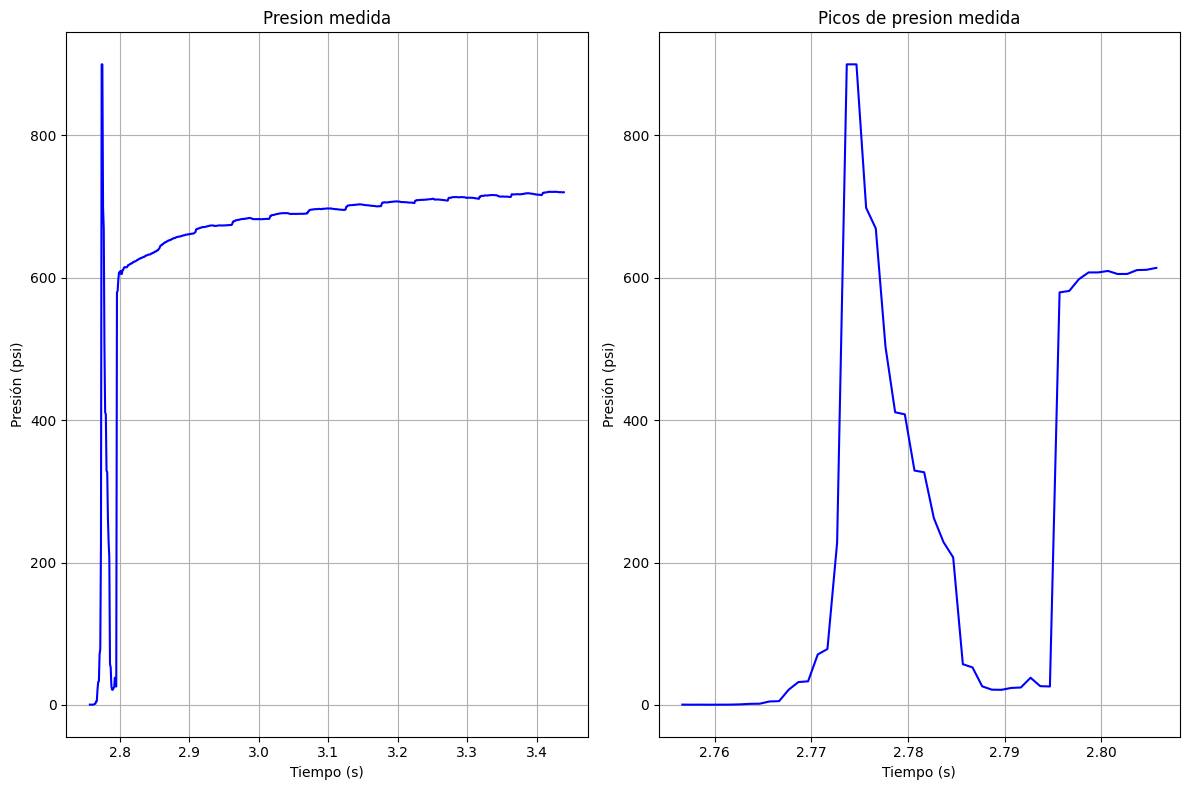

In [188]:
Presion_p = Prueba_presion[' Presión']
t_prueba = np.linspace(0, 0.001*len(Presion_p), len(Presion_p))

t_0 = -2.02
t_1 = 0.666

Pop_max = np.where(Presion_p == max(Presion_p))
t_i = int(Pop_max[0][0] - 17 )
t_f = int(Pop_max[0][0] + t_1*1000)

#print(len(t_prueba), len(Presion_p), t_prueba[Pop_max], Pop_max, Presion_p[Pop_max[0][0]], t_prueba[Pop_max[0][0]], Pop_max[0][0]+ t_0*1000, Presion_p[t_i: t_f])
print(t_prueba[-1]-t_prueba[t_i], np.mean(Presion_p[t_i: t_f]), max(Presion_p[t_i: t_f]) )

fig, ax = plt.subplots(1, 2 , figsize=(12 ,8))


ax[0].plot(t_prueba[t_i : t_f], Presion_p[t_i: t_f], 'b-', markersize = '2')
ax[0].set_title('Presion medida')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Presión (psi)')
ax[0].grid()


ax[1].plot(t_prueba[t_i : t_i+50], Presion_p[t_i: t_i+50], 'b-', markersize = '2')
ax[1].set_title('Picos de presion medida')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Presión (psi)')
ax[1].grid()

plt.tight_layout()
#plt.xlim(left=2.71)

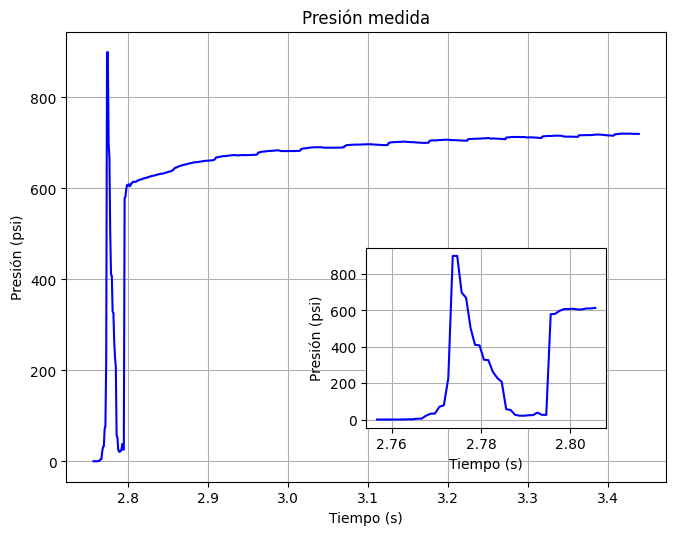

In [187]:


import matplotlib.pyplot as plt
import numpy as np

# Define tus datos de presión y tiempo aquí
Presion_p = Prueba_presion[' Presión']
t_prueba = np.linspace(0, 0.001 * len(Presion_p), len(Presion_p))
t_0 = -2.02
t_1 = 0.666
Pop_max = np.where(Presion_p == max(Presion_p))
t_i = int(Pop_max[0][0] - 17)
t_f = int(Pop_max[0][0] + t_1 * 1000)

# Crear la figura principal
fig = plt.figure(figsize=(12, 9))

# Crear la subfigura (zoom) dentro de la figura principal
left, bottom, width, height = 0.1, 0.1, 0.4*1.25, 0.5
ax_main = fig.add_axes([left, bottom, width, height])

# Graficar en la figura principal
ax_main.plot(t_prueba[t_i: t_f], Presion_p[t_i: t_f], 'b-', markersize='2')
ax_main.set_title('Presión medida')
ax_main.set_xlabel('Tiempo (s)')
ax_main.set_ylabel('Presión (psi)')
ax_main.grid()

# Crear la subfigura (zoom)
left, bottom, width, height = .35, 0.16, 0.2, 0.2
ax_zoom = fig.add_axes([left, bottom, width, height])

# Graficar en la subfigura (zoom)
ax_zoom.plot(t_prueba[t_i: t_i + 50], Presion_p[t_i: t_i + 50], 'b-', markersize='2')
#ax_zoom.set_title('Picos de presión medida (Zoom)')
ax_zoom.set_xlabel('Tiempo (s)')
ax_zoom.set_ylabel('Presión (psi)')
ax_zoom.grid()

# Mostrar la figura en pantalla
plt.show()




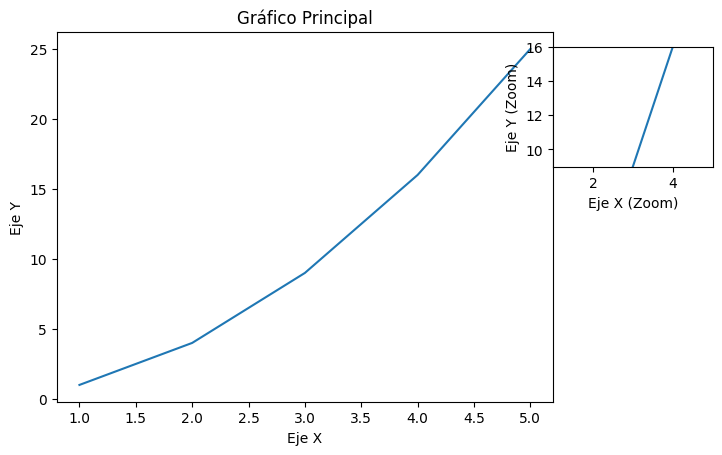

In [153]:
import matplotlib.pyplot as plt

# Crear la figura principal
fig, ax_main = plt.subplots()

# Graficar en la figura principal
ax_main.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
ax_main.set_xlabel('Eje X')
ax_main.set_ylabel('Eje Y')
ax_main.set_title('Gráfico Principal')

# Definir las coordenadas del cuadro de zoom
x_min, x_max, y_min, y_max = 1, 5, 9, 16

# Crear la subfigura (cuadro de zoom)
ax_zoom = fig.add_axes([.9, 0.6, 0.25, 0.25])  # [left, bottom, width, height]

# Graficar en la subfigura
ax_zoom.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])
ax_zoom.set_xlim(x_min, x_max)
ax_zoom.set_ylim(y_min, y_max)
ax_zoom.set_xlabel('Eje X (Zoom)')
ax_zoom.set_ylabel('Eje Y (Zoom)')
#ax_zoom.set_title('Zoom de la Gráfica')

# Guardar la figura en un archivo (opcional)
plt.savefig('figura.png')

# Mostrar la figura en pantalla
plt.show()

1.3243231632902122


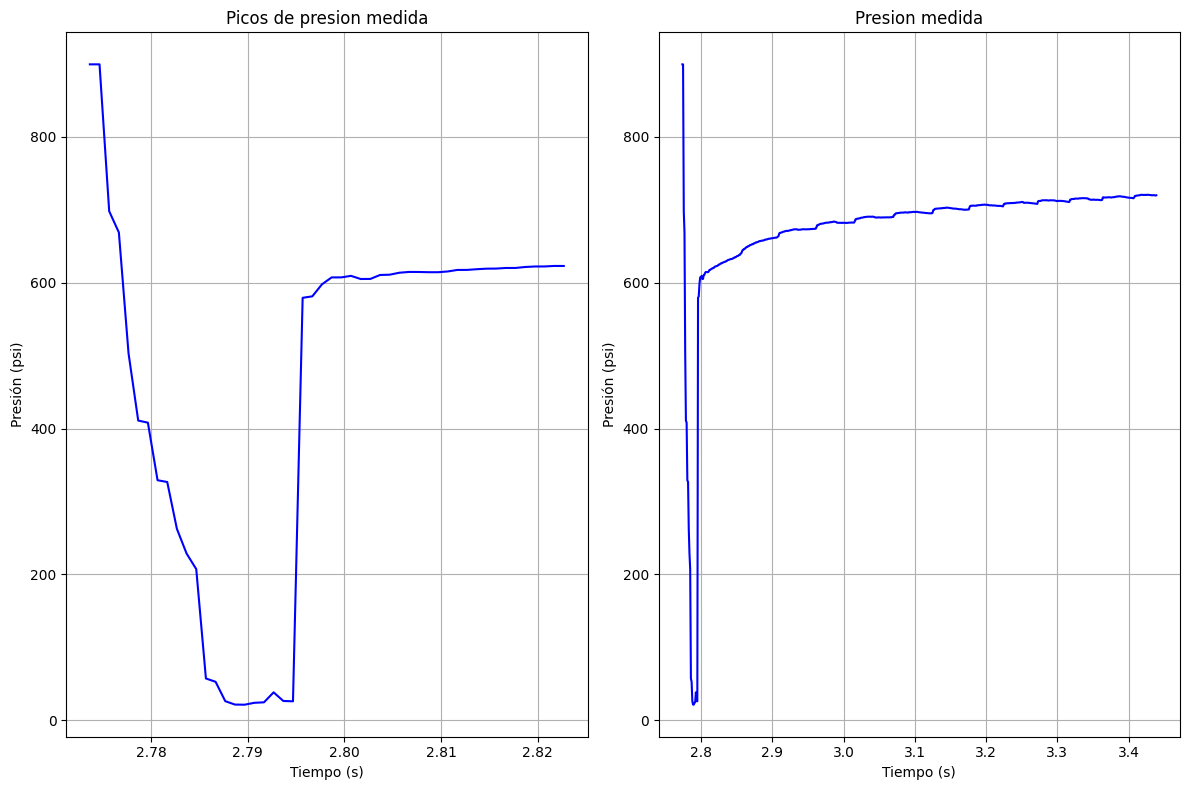

In [159]:
Presion_p = Prueba_presion[' Presión']
t_prueba = np.linspace(0, 0.001*len(Presion_p), len(Presion_p))

t_0 = -2.02
t_1 = 0.666

Pop_max = np.where(Presion_p == max(Presion_p))
t_i = int(Pop_max[0][0] )
t_f = int(Pop_max[0][0] + t_1*1000)

#print(len(t_prueba), len(Presion_p), t_prueba[Pop_max], Pop_max, Presion_p[Pop_max[0][0]], t_prueba[Pop_max[0][0]], Pop_max[0][0]+ t_0*1000, Presion_p[t_i: t_f])
print(t_prueba[-1]-t_prueba[t_i])

fig, ax = plt.subplots(1, 2 , figsize=(12 ,8))
#plt.figure(figsize=(8 ,8))
ax[0].plot(t_prueba[t_i : t_i+50], Presion_p[t_i: t_i+50], 'b-', markersize = '2')
ax[0].set_title('Picos de presion medida')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Presión (psi)')
ax[0].grid()

ax[1].plot(t_prueba[t_i : t_f], Presion_p[t_i: t_f], 'b-', markersize = '2')
ax[1].set_title('Presion medida')
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Presión (psi)')
ax[1].grid()
plt.tight_layout()
#plt.xlim(left=2.71)

# Al Can V2 (KNSU) propelente

| Compuesto              | Fórmula Química | Porcentaje |
|------------------------|-----------------|------------|
| Nitrato de potasio     | \( KNO_3 \)     | 62%        |
| Aluminio               | \( Al \)        | 3%         |
| Silicone               | \( SiO_2 \)     | 3%         |
| Azucar de mesa                | \( C_6H_{12}O_6 \) | 32%     |



## Factores de eficiencia

In [5]:
alpha = 15*np.pi/180 # angulo de la divergencia de la tobera 

N_noz = 0.85 # # eficiencia de la tobera
N_com = 0.95 # eficiencia de combustion
N_div = 1/2*(1 + np.cos(alpha)) # factor de corrección por la divergencia
N_po = 0.95 # factor de corrección de la presion de la camara

rho_rat = 0.95


In [6]:
k = 1.141607     # relación de calores especifixos
M = 0.03573117   # kg/mol masa molecular de los gases 
To_T = 1820.426    # K temperatura de combustion teorica
rho_T = 1.8892   # g/cm^3 densidad teorica



To = To_T*N_com # Temperatura "real"
rho = rho_T*rho_rat    # g/cm^3 densidad medida

# Coeficiente y exponente obtenido por Richard Nakka para el propelente KNSU
n = 0.319
a =(8.260/1000)/(10**(6*n)) # Pa, m/s


# r = 275/6 # mm/s
print(C.R/M)

232.69494444206558


# Área de quemado

# Presión

In [7]:
P0 = 800 #psi presion de la camara objetivo
Pa = 14.69594878 # presion atmosferica
Pe = Pa #psi presion de salida de la tobera

## Condiciones del Cohete

In [8]:
m=60 # masa del cohete sin propelente

theta=np.pi/2 #angulo

# Mach
Mt=1
Me=mach(Pe,P0,k)
print(Me)

3.010761166043676


In [9]:
Dc=101.6 #mm Diametro de la camara 
Ac=C.pi*(Dc/2)**2 #mm**2 # área de la camara


AtAc_l=[1/5.5] #RatArea(Mt,Mc,k)
At_l=[Ac*AtAc_l[0]]

At = At_l[-1]
Dt=diametro(At)


AeAt = RatArea(Me, Mt, k)
Ae=At*AeAt

De=diametro(Ae)

# Calculos teoricos
Cf_t = Cf_(Pe,P0, Pa, At, Ae, k)
Isp_t = Isp_(k,Pe,P0,To,M)


Cf = Cf_t*N_noz
Isp = Isp_t*N_noz*N_com*N_div*N_po # s

F_thrust = thrust(Cf,At,P0)
Ve = ex_vel(C.R/M, To, k)*Cf # Velocidad de salida de los gases de la tobera
dm = F_thrust/Ve

mp0 = m*(np.exp(np.sqrt(2*C.g*3000)/Ve)-1) # masa minima
print(mp0, Ve, np.sqrt(2*C.g*3000))

11.774539288807713 1353.7351895427316 242.56937152080843


Este analisis para obtener la masa del propelente no incluye la fuerza de fricción, por lo que se necesita resolver numéricamente las ecuaciones de movimiento como se hace posteriormente.
Para poder obtener la masa total incluyendo el propelente se puede se puede resolver con una serie geometrica de la forma
$$
\frac{M}{m}=\Sigma_{n=0}^\infty (MR)^n=\frac{1}{1-MR} ,    |MR|<1
$$
Para poder obtener un MR razonable se puede hacer un promedio de la funcion de mp/m=MR de la forma
$$
 MR=\langle \frac{m_p}{m} \rangle=\frac{1}{I_{sp}}\sqrt{\frac{2hF}{gsen\theta}} \frac{1}{b-a}\int_a^b\frac{dm}{\sqrt{Fsen\theta-mg}} 
$$
O aun mejor se puede utilizar las iteraciónes para tener un resultado mas adecuado como se muestra a continuación.

In [10]:
# Con este codigo se pretende obtener un primer valor cercano para así poder obtener la masa que se necesita con el método de las ecs diferenciales.

# Integral de mp/m
from scipy import integrate
h=3000 # altura deseada
a_1, b_1 = 40, 60
c =(1/Isp)*np.sqrt(2*h*F_thrust/(np.sin(theta)*C.g))
K = lambda m: c*(1/np.sqrt(F_thrust*np.sin(theta)-C.g*m))   

MR=1/(b_1-a_1)*(integrate.quadrature(K, a_1, b_1)[0]) # relacion de masa del propelente y el cohete

# Método iterativo 
i = 0
m_p0 = [0]
M_tot0 = [m]
error=1
while error > 10**-6:
    
    m_p0.append(M_tot0[i]*K(M_tot0[i]))
    M_tot0.append(m+m_p0[i+1])
    error = M_tot0[i+1]-M_tot0[i]
    #print(error, M_tot[-1])
    i+=1

# Mtot = m*(1/(1-MR)) # masa total con calculo de promedio

# h1 = altura(Mtot ,Mtot-m, F, Isp, np.pi/2) #altura alcanzada
h2 = altura(M_tot0[-1] ,m_p0[-1], F_thrust, Isp, np.pi/2) # Altura con metodo iterativo
t = Isp*(M_tot0[-1]-m)*C.g/F_thrust # tiempo de empuje


print( t, M_tot0[-1], m_p0[-1], h2, Isp) # mm

1.7242946052939767 75.86747568949708 15.867475689497088 2999.99995010474 122.4608827376444


## Dimensiones de la tobera

In [11]:

ApAt=2
Dp = np.sqrt(ApAt)*Dt #Diametro del port

# Área de quemado
V0 = mp0*1000/rho # cm^3 Volumen con densidad experiemental del grano

Va0 = (V0)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3

L0 = Va0*10**3/Ac # mm  Longitud del grano con densidad experimentale

p0 = [4, Dc-.6, Dp, L0/4] #  N, D, d, L, At, = p
Ab0 = Ab_(0,1,1, p0)

Kn_max= Kn_pol(P0)
Kn = Kn_(At, Ab0[-1])

At2 = max(Ab0[-1])/Kn_max






print(Dc,Dt,De, Ac, At, Ae, AeAt)
#print(Dc, Dt, De, Dp)
#print(diametro(At), diametro(At2), L0, Kn_max, Kn)

101.6 43.32238556346004 125.64924948918002 8107.319665559963 1474.0581210109024 12399.657207063969 8.41191879093637


# Determinantes del rendimiento

In [12]:


# Calculos con factores de eficiencia
Cf = Cf_t*N_noz
F = thrust(Cf,At,P0)
Isp = Isp_t*N_noz*N_com*N_div*N_po # s

Ve = ex_vel(C.R/M, To, k)*Cf # Velocidad de salida de los gases de la tobera
dm = F/Ve # flujo masico

print(Cf, F, Isp, dm, Ve, ex_vel(C.R/M, To, k))

1.359223498817372 11051.327097970014 122.4608827376444 8.163581166640842 1353.7351895427316 995.962173049969


918.7909390042106 822.4243055249157 1.3932448104699497


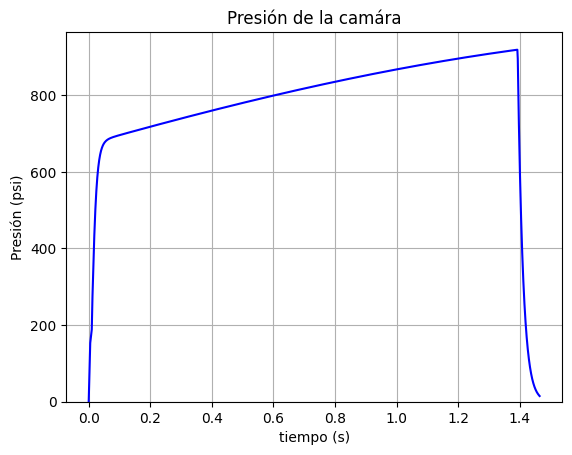

In [13]:
# Superficies de quemado
Bs = [0, 1, 1, 4]

Datos = 1000
t_web0 = np.array([(Dc-0.6-Dp)/2])
Xinc = np.linspace(0, t_web0[0]/(1+Bs[0]*Bs[1]), Datos)
t_web = np.append(t_web0, t_web0[0]-Xinc)

D = Dc-0.6 - Bs[0]*2*Xinc
d = Dp + Bs[1]*2*Xinc
L = L0 - Bs[2]*Bs[3]*2*Xinc

Vc = np.pi*(Dc/2)**2*L0/(1000**3) # m^3
V_G = 1/4*np.pi*(D**2-d**2)*L/(1000**3) # m^3
V_F = Vc - V_G

P_a = 0.101325

Po_abs1 = [] # En Pa
Po_abs2 = [P_a] # En Mpa
m_grain = rho*1000*V_G # kg
m_gen = [0]
m_noz = [0]
m_sto = [0]
mass_sto = [0]
rho_prod = []
t1 = [0]
a1 = 8.260
#r = lambda P: a1*P**n
R = [a1*(Po_abs2[0]**n)]

for i in range(len(Xinc)-1):
    rho_prod.append(mass_sto[i]/V_F[i])


    Po_abs1.append(rho_prod[i]*C.R/M*To+P_a*10**6)
    Po_abs2.append(Po_abs1[i]/(10**6))
    R.append(a1*(Po_abs2[i])**n)
    t1.append(Xinc[1]/R[i+1] + t1[i]) #2
    m_gen.append((m_grain[i]-m_grain[i+1])/(t1[i+1]-t1[i]))
    
    # print(mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M), Po_abs2[i+1]-P_a, Po_abs1[i])
    if m_gen[i+1] < mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M):
        if Po_abs2[i+1] > 0:
            m_noz.append( mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M))
        else :
            m_noz.append(0)
    else :
        m_noz.append(mdot(At/(10**6),(Po_abs2[i+1]-P_a)*10**6, k,To,C.R/M))
    
    m_sto.append(m_gen[i+1]-m_noz[i+1])
    

    #print(m_sto, t1, mass_sto, i)
    if m_sto[i+1]*(t1[i+1]-t1[i]) + mass_sto[i] < 0 :
        mass_sto.append(0)
    else :
        mass_sto.append(m_sto[i+1]*(t1[i+1]-t1[i]) + mass_sto[i])

Vc = Va0*10**-6
A_t = At*10**-6
A_e = Ae*10**-6

Po_gage =  np.array(Po_abs2) - P_a
Po_max = max(Po_abs2) - P_a
Po_final = (0.02/100)*Po_max + P_a

t_final = -np.log(Po_final/(Po_abs1[-1]*10**-6))*((Vc)*ex_vel(C.R/M, To, k))/(C.R/M*To*(A_t))
t2 = np.linspace(t1[-1], t1[-1]+ t_final, 100)

t_thrust = np.append(np.array(t1), t2[1:])

A1 = (C.R/M)*To*(A_t)*(t2[1:]-t1[-1])
A2 = (Vc)*ex_vel(C.R/M, To, k)

Pc = np.array(Po_abs2[-1]*(np.exp(-A1/A2)))

Po_gage = np.array(Po_abs1)*10**-6 - P_a
Presion_camara = np.append(Po_gage, Pc)


print( Po_max*1000000/6895, np.mean(Po_abs2)*1000000/6895, t1[-1])


#print(Po_final, Po_abs1[-1]*10**-6,Pc[-1], t2[-1], (C.R/M)*To*(At/10**6)/A2, At, t2[1]-t2[0])
plt.plot(t_thrust[0:-1], Presion_camara*1000000/6895, 'b-')
plt.ylim(bottom=0)
plt.ylabel('Presión (psi)')
plt.xlabel('tiempo (s)')
plt.title('Presión de la camára')
plt.grid()
plt.show()


# print(Xinc[1], R[1], t1[-1], rho_prod[1], mass_sto[1], m_sto[1], m_noz[1],m_gen[1], m_grain[0], m_grain[1], Pc[-1], t2[0]==t1[-1], t2[1]-t2[0], t_final) # 1,1,1,0,0,0,1


In [14]:
print(len(Presion_camara), len(t_thrust))

1098 1099


13074.021011954528 10612.922375981052 15933.027198458323 Isp = 137.98557852305944


C:\Users\leo_1\AppData\Local\Temp\ipykernel_7484\2217227967.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)
C:\Users\leo_1\AppData\Local\Temp\ipykernel_7484\2217227967.py:18: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)
C:\Users\leo_1\AppData\Local\Temp\ipykernel_7484\2217227967.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt((2*k**2/(k-1)*(2/(k+1))**a)*(1-(Pe/P0)**((k-1)/k))) + (Pe - Pa)*Ae/(P0*At)


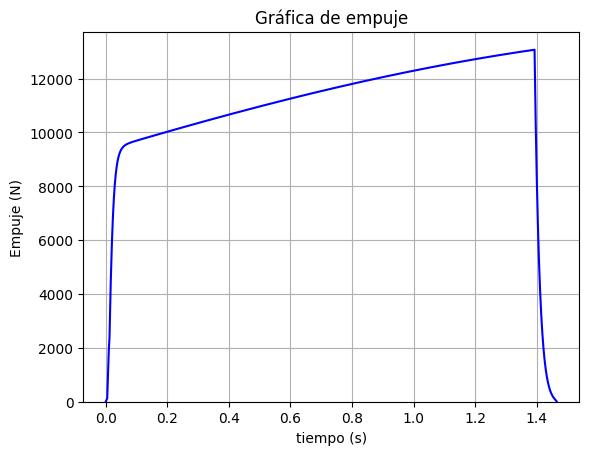

In [15]:
F = [0]
C_f = [N_noz]
P_e =[]
Ae_At = [1]
I_t = [0]
abc = np.append(np.array(Po_abs1)*10**-6, Pc)
Po_thrust = np.append(abc, 0)
P = lambda Po: Po*(1+(k-1)/2*Me**2)**(-k/(k-1))
for i in range(len(t_thrust)-1):

    if P(Po_thrust[i]*10**6) < P_a*10**6:
        P_e.append(P_a*10**6)
    else :
        P_e.append(P(Po_thrust[i]*10**6))
    
    C_f.append(N_noz*Cf_(P_e[i], Po_thrust[i+1]*10**6, P_a*10**6, A_t, A_e, k))

    F.append(C_f[i]*Po_thrust[i]*10**6*A_t)

    I_t.append((F[i+1] + F[i])/2*(t_thrust[i+1]-t_thrust[i]))
#print(Po_thrust)
#print(C_f) # hay un problema con el inicio de la gráfica
print(max(F), np.mean(F), sum(I_t), f'Isp = {sum(I_t)/(C.g*mp0)}')
plt.plot(t_thrust, F, 'b-')
plt.ylim(bottom=0)
plt.ylabel('Empuje (N)')
plt.xlabel('tiempo (s)')
plt.title('Gráfica de empuje')
plt.grid()
plt.show()





(1099,)


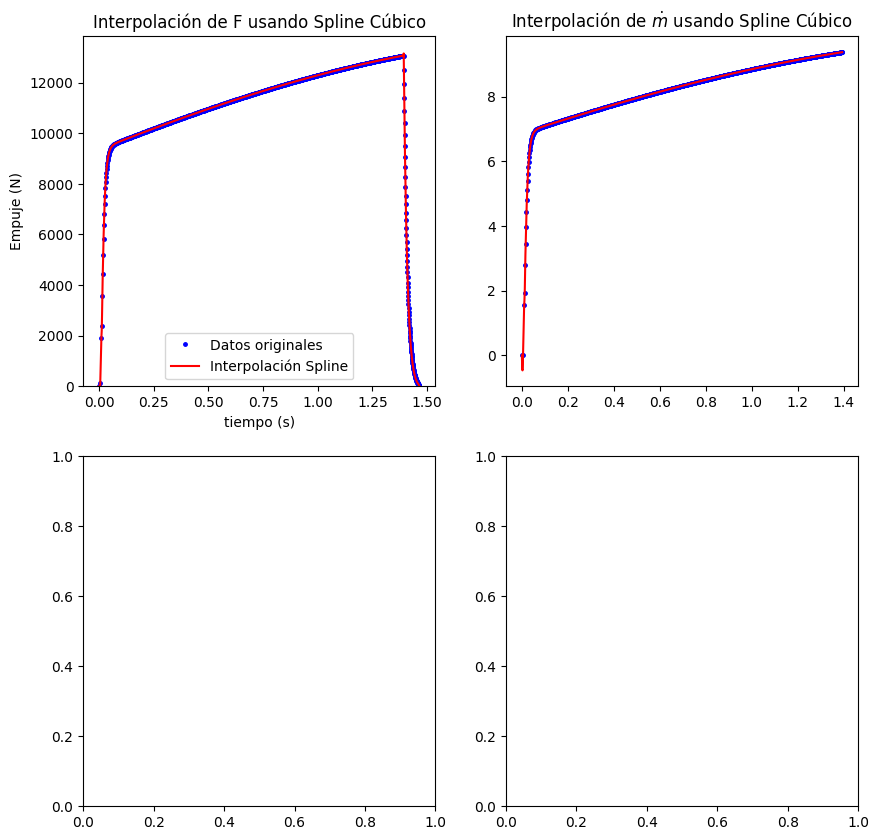

In [16]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Asumiendo que t_thrust y F ya están definidos:
# t_thrust = [...]
# F = [...]

#print(np.squeeze(t1))
print(np.shape(np.squeeze(t_thrust)))
# Crear una función spline para F en función del tiempo t_thrust
F_spline = CubicSpline(t_thrust, F)
m_noz_spline = CubicSpline(t1, m_noz)

t1_new = np.linspace(t1[0], t1[-1], 1000)
m_noz_new = m_noz_spline(t1_new)


# Opcional: Graficar para verificar la interpolación
t_new = np.linspace(min(t_thrust), max(t_thrust), 1000)
F_new = F_spline(t_new)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0,0].plot(t_thrust, F, 'bo', markersize='2.5', label='Datos originales')
ax[0,0].plot(t_new, F_new, 'r-', label='Interpolación Spline')
ax[0,0].legend()
ax[0,0].set_xlabel('tiempo (s)')
ax[0,0].set_ylabel('Empuje (N)')
ax[0,0].set_title('Interpolación de F usando Spline Cúbico')
ax[0,0].set_ylim(bottom=0)

ax[0,1].plot(t1, m_noz, 'bo', markersize='2.5', label='Datos originales' )
ax[0,1].plot(t1_new, m_noz_new, 'r-')
ax[0,1].set_title(r'Interpolación de $\dot{m}$ usando Spline Cúbico')

plt.show()


# Trayectoria y altura

01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho

def F(t, t_thrust):
    return np.piecewise(t, [t < t_thrust, t >= t_thrust], [F_spline(t), 0])

def dm(t, t_b):
    return np.piecewise(t, [t < t_b, t >= t_b], [m_noz_spline(t), 0])



# Sistema de ecuaciones
def sis(CI, t, p):
    m, Cd, A, t_thrust, t_b, theta, fase = p
    x, u, y, v = CI

    F_t = F(t, t_thrust)
    dm_t = dm(t, t_b)
    
    dxdt = u
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.sin(theta) - C.g
    
    return [dxdt, dudt, dydt, dvdt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]






h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 1000)
    p1 = [M_tot[i], Cd , A, t_thr, t1[-1], theta, 1]
    Sol_1 = odeint(sis, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, t_thr, t1[-1], theta, 0]
    Sol_2 = odeint(sis, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.005)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    print(h[i])
    i+=1
    

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

 # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()

In [17]:

# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho

def F_(t, t_thrust):
    return np.piecewise(t, [t < t_thrust, t >= t_thrust], [F_spline(t), 0])

def dm_(t, t_b):
    return np.piecewise(t, [t < t_b, t >= t_b], [m_noz_spline(t), 0])



# Sistema de ecuaciones
def sis(CI, t, p):
    m, Cd, A, t_thrust, t_b, theta, fase = p
    x, u, y, v = CI

    F_t = F_(t, t_thrust)
    dm_t = dm_(t, t_b)
    
    dxdt = u
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.sin(theta) - C.g
    
    return [dxdt, dudt, dydt, dvdt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]






h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 1000)
    p1 = [M_tot[i], Cd , A, t_thr, t1[-1], theta, 1]
    Sol_1 = odeint(sis, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, t_thr, t1[-1], theta, 0]
    Sol_2 = odeint(sis, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.05)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    print(h[i])
    i+=1
    

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

 # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()


0
2009.3436944091204
2026.199897870219
2043.1149987760048
2060.088735614392
2077.1167683210724
2094.204467181954
2111.348697177783
2128.5464800744717
2145.8048050272523
2163.117282300339
2180.4833497179297
2197.9096426349706
2215.388201207572
2232.9218569164054
2250.5127569130223
2268.15517838905
2285.8543026924385
2303.6076044824363
2321.4116986374065
2339.274394736071
2357.187702093864
2375.1621879274767
2389.480219043846
2398.651799809407
2404.1428671913495
2407.005839260266
2407.9981930316394
2407.6692150904737
2406.4055158140986
2404.486781660687
2402.109413044989
2399.4146253770714
2396.495225242039
2393.4206906061586
2390.23460754446
2386.731323065516
2381.1209122707533
2369.0848429395073
2343.77499776001
2295.9553601097564
2214.449571472605
2086.6846167956937
1900.3408491931666
1645.7988566267318
1320.8878339050732
939.3126994986225
545.529942109192


c:\Users\leo_1\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


238.1321719644213
165.3629362126386
165.30195706619705
165.17596046829433
165.04915664257547
164.92302309269002
164.79765808516106
164.66966423138993
164.5465926328217
164.41963186464426
164.29422077488394
164.17077813720095
164.0447606162999
163.9180702517515
163.79593364328503
163.67216885563116
163.54715501771403
163.4212715976362
163.29734375399855
163.17517096559908
163.0524669513932
162.92946416789405
162.80634352327266
162.68324855431774
162.56030105372233
162.43756665276885
162.31509008291476
162.19286300112756
162.07086810288504
161.9490199132467
161.82721548695335
161.70530765207857
161.58312586852185
161.46044058498848
161.33811698574974
161.21935816441152
161.09988020933633
160.9793492838257
160.85738295823066
160.73524939834465
160.61803726359437
160.49865631326276
160.37663875813746
160.2574959712719
160.13997380872846
160.01874152470202
159.89986299403753
159.78260140195457
159.6602789714358
159.54487960867118
159.42551546424275
159.3069403992664
159.19001346160437
159.0

KeyboardInterrupt: 

90.74767369808671 1.5702521091886121 0.03145874441077082 1949.4692323080478


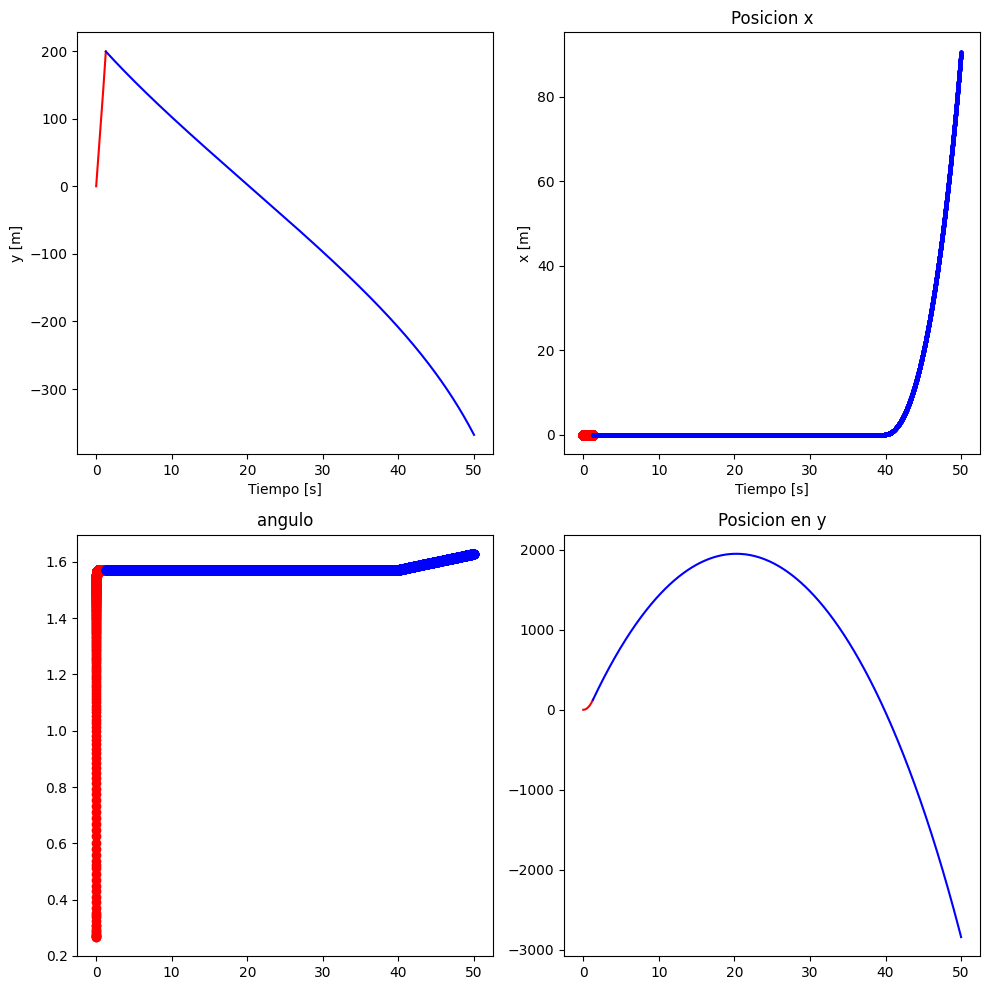

In [34]:
# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import solve_ivp

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho



# Sistema de ecuaciones
def sis(t, CI, p):
    m, Cd, A, F_t, dm_t, fase = p
    u, theta, x, y = CI

    
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2)) - C.g*np.sin(theta)

    dvdt = -(C.g/u - u/np.sqrt(x**2 + y**2))*np.cos(theta)
    
    
    dxdt = u*np.cos(theta)
    dydt = u*np.sin(theta)
    
    return [dudt, dvdt, dxdt, dydt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]

#theta_spline = CubicSpline(t2, Sol_2[:,2])
#Vel_spline = CubicSpline(t2, Sol_2[:,1])

#t2_new = np.linspace(t2[0], t2[-1], 1000)

#N = lambda t : theta_spline(t)*Vel_spline(t)


theta = np.pi/6 

h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while i < 1:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0.001, theta, 0.001, 0.001] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 10000)
    p1 = [M_tot[i], Cd , A, F_thrust, dm, 1]
    Sol_1 = solve_ivp(sis, [0, t_thr] , CI1, args=(p1, ), t_eval=t1)

    # Calculos fase 2
    

    CI2 = [Sol_1.y[0,-1], Sol_1.y[1, -1], Sol_1.y[2, -1], Sol_1.y[3, -1]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 10000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, 0, 0, 0]
    Sol_2 = solve_ivp(sis, [t_thr, 50] , CI2, args=(p2, ), t_eval=t2)



    #h.append(max(Sol_2[:,1]*np.cos(Sol_2[:,2])))

    #if h[i+1] < h0:
        #M_tot.append(M_tot[i] + 0.005)
        #m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    # print(h[i+1])
    i+=1
    

#Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax[0,0].plot(Sol_1.t, Sol_1.y[0], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax[0,1].plot(Sol_1.t, Sol_1.y[2], 'ro') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax[0,0].plot(Sol_2.t, Sol_2.y[0], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax[0,1].plot(Sol_2.t, Sol_2.y[2], 'bo', markersize='2') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x

ax[0,1].set_title('Posicion x')


ax[0,0].set_xlabel('Tiempo [s]')
ax[0,0].set_ylabel('y [m]')
#ax1.set_ylim(bottom=0)

ax[0,1].set_xlabel('Tiempo [s]')
ax[0,1].set_ylabel('x [m]')
#ax2.set_ylim(bottom=0)


ax[1,0].plot(Sol_1.t, Sol_1.y[1], 'ro')
ax[1,0].plot(Sol_2.t, Sol_2.y[1], 'bo')
ax[1,0].set_title('angulo')

ax[1,1].plot(Sol_1.t,Sol_1.y[3] , 'r-')
ax[1,1].plot(Sol_2.t,Sol_2.y[3] , 'b-')
ax[1,1].set_title('Posicion en y')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

#print( Sol_2.y[2])
print(max(Sol_2.y[2]), min(Sol_2.y[1]), Sol_2.y[2, 0], max(Sol_2.y[3]))




#print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()

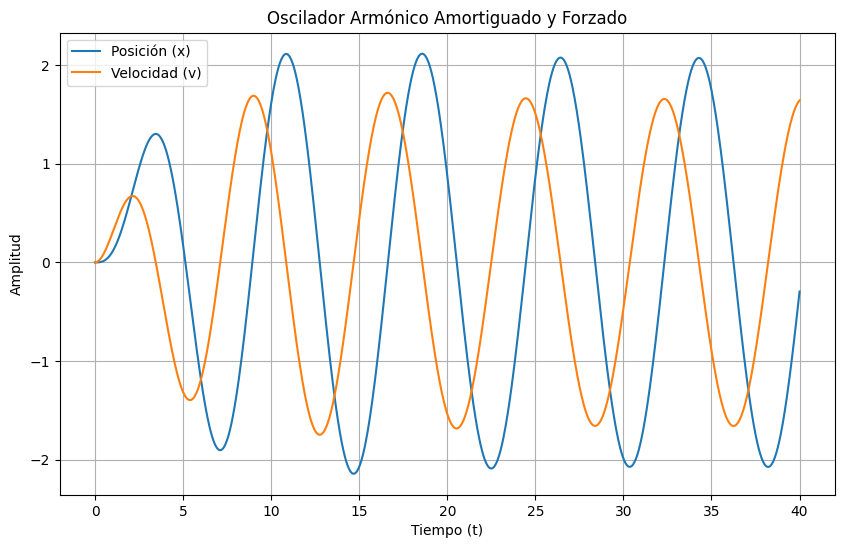

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Definir el sistema de ecuaciones diferenciales
def damped_driven_oscillator(t, z, omega0, zeta, F0, omega):
    x, v = z
    dxdt = v
    dvdt = -2 * zeta * omega0 * v - omega0 ** 2 * x + F0 * np.sin(omega * t)
    return [dxdt, dvdt]

# Parámetros del sistema
omega0 = 1.0   # Frecuencia natural
zeta = 0.2     # Tasa de amortiguamiento
F0 = 1.0       # Amplitud de la fuerza externa
omega = 0.8    # Frecuencia de la fuerza externa

# Condiciones iniciales
x0 = 0.0
v0 = 0.0
initial_conditions = [x0, v0]

# Definir el rango de tiempo
t_span = (0, 40)
t_eval = np.linspace(*t_span, 1000)

# Resolver el sistema de ecuaciones diferenciales
solution = solve_ivp(damped_driven_oscillator, t_span, initial_conditions, args=(omega0, zeta, F0, omega), t_eval=t_eval)

# Extraer los resultados
t = solution.t
x, v = solution.y

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Posición (x)')
plt.plot(t, v, label='Velocidad (v)')
plt.xlabel('Tiempo (t)')
plt.ylabel('Amplitud')
plt.title('Oscilador Armónico Amortiguado y Forzado')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente


## copia de seguridad
from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho



# Sistema de ecuaciones
def sis(CI, t, p):
    m, Cd, A, F_t, dm_t, theta, fase = p
    x, u, y, v = CI

    
    dxdt = u
    dudt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt = (1/(m-fase*(dm_t)*t))*(fase*F_t - 0.5*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.sin(theta) - C.g
    
    return [dxdt, dudt, dydt, dvdt]


# Parámetros
# p = [m, Cd, A, t_thrust, t_b, theta, fase]






h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)


# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    t_thr = Isp*C.g*m_p[i]/F_thrust # tiempo de empuje

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, t_thr, 1000)
    p1 = [M_tot[i], Cd , A, F_thrust, dm, theta, 1]
    Sol_1 = odeint(sis, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(t_thr,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, 0, 0, theta, 0]
    Sol_2 = odeint(sis, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.005)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])
    print(h[i])
    i+=1
    

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

 # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(t_thr, max(h), m_p[-1], Fd_max, It, F_thrust/m) 

plt.tight_layout()
plt.show()

In [ ]:
# 01-10-2023: Aún se tiene que checar como es que cambia la masa durante el vuelo de la fase 1, para mejorar la masa que se necesita de propelente

from scipy.integrate import odeint

# Variación de la densidad del aire segun la altura.
def densidad_aire(h):
    # Definición de constantes
    rho_0 = 1.225  # kg/m^3
    g = C.g  # m/s^2
    M = 0.02897  # kg/mol
    R = 8.3144598  # J/mol·K
    T0 = 288.15  # K

    rho = rho_0 * np.exp(-g * M * h / (R * T0))
    return rho

# Sistema de ecuaciones
def f(CI, t, p):
    m, Cd, A, F, theta, fase = p
    x, u, y, v, = CI

    dxdt = u
    dudt =  (1/(m-fase*(dm)*t))*(fase*F - 1/2*densidad_aire(y)*A*Cd*(u**2 + v**2))*np.cos(theta)

    dydt = v
    dvdt =  (1/(m-fase*(dm)*t))*(fase*F - 1/2*densidad_aire(y)*A*Cd*(u**2 + v**2)*np.sin(theta)) - C.g
    return [dxdt, dudt, dydt, dvdt]

h0 = 3000 # altura deseada 

Cd = 0.333 # coeficiente de arrastre
A = np.pi*(6/(2*39.37))**2 # área transversal (6 inch esn el diametro del tubo de fuselaje)

# Ciclo iterativo
i=0
m_p = [mp0] # se utiliza la formula del método que no se considera la fuerza de arrastre para la primera iteración
M_tot = [m + mp0]
h = [0]
while h[i] < h0:

    tf = Isp*(M_tot[-1]-m)*C.g/F_thrust

    # Calculos fase 1
    CI1 = [0, 0, 0, 0] # Condiciones iniciales x0, Vx0, y0, Vy0
    t1 = np.linspace(0, tf, 1000)
    p1 = [M_tot[i], Cd , A, F_thrust, theta, 1]
    Sol_1 = odeint(f, CI1, t1, args=(p1, ))

    # Calculos fase 2
    

    CI2 = [Sol_1[-1,0], Sol_1[-1,1], Sol_1[-1,2], Sol_1[-1,3]] # Condiciones iniciales
    t2 = np.linspace(tf,  50, 1000) # Si en la gráfica no se ve todo el descenso cambiar el tiempo final
    p2 = [m, Cd , A, 0, theta, 0]
    Sol_2 = odeint(f, CI2, t2, args=(p2, ))
    

    h.append(max(Sol_2[:,2]))

    if h[i+1] < h0:
        M_tot.append(M_tot[i] + 0.005)
        m_p.append(M_tot[i+1]-m)

    #print(M_tot[i], h2[-1])

    i+=1

Fd_max = 1/2*(p1[1]*p1[2]*densidad_aire(Sol_1[-1, 2])*(Sol_1[-1,3]**2+Sol_1[-1,1]**2)) # Fuerza de arrastre maxima
fig, (ax1, ax2) = plt.subplots(2, figsize=(7, 7))


#print(tf, F, Sol_1[-1,0], Sol_1[-1,1])
# Primera fase
ax1.plot(t1, Sol_1[:, 2], 'r-') # posición en y 
#ax1.plot(t1, Sol_1[:, 3], 'g-') # velocidad en y
ax2.plot(t1, Sol_1[:, 0], 'r-') # posición en x
#ax2.plot(t1, Sol_1[:, 1], 'g-') # velocidad en x

# Segunda fase
ax1.plot(t2,Sol_2[:, 2], 'b-') # posición en y
#ax1.plot(t2, Sol_2[:, 3], 'm-') # velocidad en y
ax2.plot(t2, Sol_2[:, 0], 'b-') # posición en x
#ax2.plot(t2, Sol_2[:, 1], 'm-') # velocidad en x


ax1.set_xlabel('Tiempo [s]')
ax1.set_ylabel('y [m]')
ax1.set_ylim(bottom=0)

ax2.set_xlabel('Tiempo [s]')
ax2.set_ylabel('x [m]')

# se tiene que arreglar las gráficas, porque la parte del decenso es diferente ya que esta es con paracaidas.

It = Isp*C.g*m_p[-1]

L3 = M_tot[-1]-(dm)*tf # el extra de 3.45 es para que se cumpla que al tiempo tf la masa total sea igual a la masa sin propelente solo que  se tiene que 
#justificar de alguna otra manera, si se agragamos ese extra a las ecuaciones diferenciales, nos quita 400 gramos de la masa del propelente.

print(tf, max(h), m_p[-1], Fd_max, It, L3, F_thrust/m) 

plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for *: 'int' and 'function'

In [ ]:
# Nueva manera de como obtener la masa del propelente aproximada, se necesita mas información pero realmente es un valor cercano a lo que se puede esperar
# con mi método

v1 = 1.2*np.sqrt(2*C.g*3000)
m1 = m*(np.exp(v1/(Isp*C.g))-1) 
print(m1)

16.456800582610498


## Volumen propelente
Para obetner un buen flujo de los gases de la camara con una relación $L/D=6$
$$
\frac{A_p}{A_t}=\frac{\pi D^2(1-V_1)}{4A_t}
$$
Donde D es el diametro del propelente y V1 es la relación de propelente y volumen de la camara
$$
V_1=\frac{V_p}{V_a}
$$
Donde $V_p$ es el volumen del propelente y $V_a$ es el volumen valido de la camara. Despejando para $V_a$
$$
V_a=\frac{V_p}{1-\frac{A_p}{A_t}A_t\frac{4}{\pi D^2}}
$$

In [ ]:
# Longitud de la camara 

V = m_p[-1]*1000/rho # cm^3 Volumen con densidad experiemental
V_t = m_p[-1]*1000/rho_T # cm^3 Volumen con densidad teorica
L = V_t*1000/Ac # mm  Longitud del grano solido sin huecos
# print(MR, K(50), Mtot, h1)

ApAt=1.9


Dp = np.sqrt(ApAt)*Dt #Diametro del port

Va1 = (V)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3
L = Va1*10**3/Ac # mm  Longitud del grano con densidad experimentale

Va2 = (V_t)/(1-ApAt*At*4/(np.pi*Dc**2)) # cm^3
L_t = Va2*10**3/Ac # mm L_t=L_g

# L_g= V_t*10**3/(Ac-ApAt*At) ## mm longitud del grano con densidad teorica
Wf = (Dc-Dp)/Dc

print(Wf, V/Va1,L, L/Dc , L_t, L_t/Dc, Dp, Dt)

0.41224618635474136 0.6545454545454545 1416.9671795828547 13.946527358098963 1346.1188206037118 13.249200990194014 59.71578746635827 43.32238556346004


In [ ]:

p = [4, Dc-.6, Dp, L/4] #  N, D, d, L, At, = p
Ab = Ab_(0,1,1, p)

Kn = Kn_(At, Ab[3])

Kn_max = Kn_pol(P0)

At2 = max(Ab[3])/Kn_max

At_l.append(At2)
AtAc_l.append(At2/Ac)

P_0 = presion(Kn_max, a, rho*1000, n, k, C.R/M, To*N_com)/6895.76 # psi

AeAt2 = RatArea(mach(Pe,P_0,k), 1, k)

print(Kn, P_0, Kn_max, diametro(At2), diametro(AeAt2*At), diametro(At_l[-1]))

[208.61859158397212, 242.67056068034918, 269.4648412829856] 909.9336390735468 242.7022594294697 45.64849961185772 132.13069167538416 45.64849961185772


In [ ]:
print(8.260*0.10128398**n)

3.9787582246731867


## Datos obtenidos
Aquí se muestra en una tabla todos los datos importantes que se calcularon para la misión relacionados con motor (Por completar)